# Pfam dataset classification

Detailed description of the pipeline is provided in the report.

First let's import the necessary packages for the project and load the different datasets from the their respective directories.

In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.manifold import TSNE
from collections import Counter
import circlify
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import tensorflow.keras.layers as layers
import warnings
# warnings.filterwarnings('ignore') #hidden for display purposes


#load data
dataset_folder = "./random_split"

def load_dataset(split: str) -> pd.DataFrame:
    """
    returns the set of a given directory name in a pandas dataframe
    """
    data_chunks = glob.glob(f"{dataset_folder}/{split}/*")
    read_data_chunks = [pd.read_csv(data_chunk) for data_chunk in data_chunks]
    read_df = pd.concat(read_data_chunks, ignore_index=True)
    read_df["split"] = split
    return read_df

raw_train_df = load_dataset("train")
raw_dev_df = load_dataset("dev")
raw_test_df = load_dataset("test")

In [2]:
#Params
num_labels = 100
max_seq_len = 300
embedding_dim = 32
#Training config
EPOCHS = 10
BATCH_SIZE = 32
patience = 5

## Exploring the data

First things first, we dig in the data to look for any patterns and trends. Pandas provides a nice functionality of describing the dataset using the *.describe()* function. The training set is massive, with more than million sequences belonging to approx. 18,000 protein families. The most frequent protein family in all 3 datasets is *Methyltransf_25*, which occurs 3,637 times in the traininig dataset and 454 times in the held-out set and the test set. The heldout set and test set are of the same size, both with 126,171 sequences belonging to 13,071 families. 

Overall, the split was done in 80% / 10% / 10% manner, whereby roughly 80%  of the sequences where assigned to the training set, and the remainder was equally divided between the heldout set and thetest set. The split seems to have been carefully done as to have all possible family IDs in the data represented in the training set. In other words, all family IDs that appear in the heldout and test set appear also in the training set, which helps improve the generalizability of the subsequent model in the later stages of the project.

The accession number in form **PFxxxxx.y** (Pfam), where **xxxxx** is the family accession, and **y** is the version number. With that in mind, we check whether we have different versions of the same family in the dataset. 


In [3]:
raw_train_df.describe()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,split
count,1086741,1086741,1086741,1086741,1086741,1086741
unique,17929,1086741,17929,1086326,1086315,1
top,Methyltransf_25,A4WZS5_RHOS5/416-539,PF13649.6,GLFRF..SL..........S....D.F...C.N...........K....,GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...,train
freq,3637,1,3637,31,32,1086741


In [4]:
deversioned = raw_train_df["family_accession"].map(lambda x: x.split(".")[0])
len(deversioned.unique())

17929

There seems to be no redundancies in the protein family IDs if the verison is discounted

In [5]:
raw_test_df.describe()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,split
count,126171,126171,126171,126171,126171,126171
unique,13071,126171,13071,126161,126161,1
top,Methyltransf_25,R6RQF6_9CLOT/17-251,PF13649.6,ELYLL..SL..........S....E.N...V.N...........V....,ELYLLSLSENVNVVSSLTKENKKRKRTPDVSSKLWHCRLGHISRGR...,test
freq,454,1,454,3,3,126171


In [6]:
raw_dev_df.describe()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,split
count,126171,126171,126171,126171,126171,126171
unique,13071,126171,13071,126150,126150,1
top,Methyltransf_25,N1QB11_PSEFD/15-76,PF13649.6,GLFRF..SL..........S....D.F...C.N...........K....,GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...,dev
freq,454,1,454,9,9,126171


In [7]:
# some stats over splits
count_all = len(raw_train_df) + len(raw_dev_df) + len(raw_test_df)

train_perc = round((len(raw_train_df)/ count_all) * 100, 2)
dev_perc = round((len(raw_dev_df)/ count_all) * 100, 2)
test_perc = round((len(raw_test_df)/ count_all) * 100, 2)

train_labels = raw_train_df["family_accession"].unique()
dev_labels = raw_dev_df["family_accession"].unique()
test_labels = raw_test_df["family_accession"].unique()


pd.DataFrame({ "Count": [len(raw_train_df), len(raw_test_df), len(raw_dev_df)],
    "Count_unique": [len(train_labels), len(test_labels), len(dev_labels)],
    "Percent": [train_perc, test_perc, dev_perc],}, index = ["train", "test", "dev"])

,Count,Count_unique,Percent
train,1086741,17929,81.16
test,126171,13071,9.42
dev,126171,13071,9.42


In [8]:
pd.DataFrame({
    "proportion overlapping with training set": [
        len(set(dev_labels).intersection(train_labels)) / len(dev_labels), 
        len(set(test_labels).intersection(train_labels)) / len(test_labels)
    ]}, index = ["dev", "test"])

,proportion overlapping with training set
dev,1.0
test,1.0


### Protein Family distribution

,Count of top ith Family
1,4545
10,1512
50,1017
100,884
150,780
200,731
250,675
500,461
1000,284


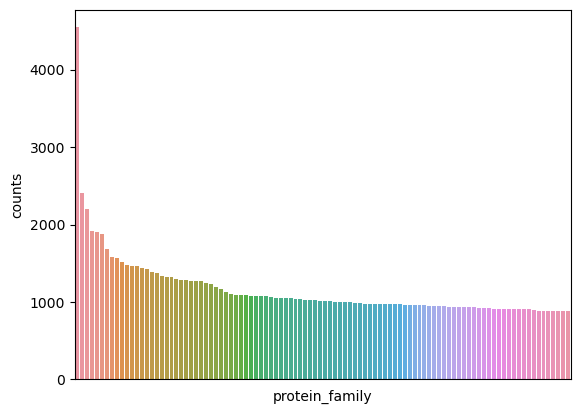

In [9]:
# df with top 100 labels and their count 
all_seq_df = pd.concat([raw_train_df, raw_dev_df, raw_test_df])
all_labels = all_seq_df["family_accession"].unique()
labels_count  = all_seq_df.value_counts("family_accession")

top_families = pd.DataFrame({ 
    "protein_family":  labels_count.iloc[:num_labels].index.to_list(),
    "counts" : labels_count.iloc[:num_labels].to_list()
})

sns.barplot(x = "protein_family", y="counts", data=top_families)
plt.xticks([])

#checking families with different sizes
x = [1, 10, 50, 100, 150, 200, 250, 500, 1000]
y = [labels_count[i-1] for i in x]
count_ith_fam = pd.DataFrame({"Count of top ith Family": y}, index = x)
count_ith_fam

If we order the families in decreasing order of sequence count, we see that the data is heavily imbalanced, with the top family having more than 4,500 sequences and the following 9 families counting  more than 1,500 sequences each. From the 50th larger family has roughly 100 sequences, and the number drops from there on more steadily till below 280 after the 1,000th family. A clearer depiction of the difference in sizes can be seen in the Bubble chart below, depicting the comparative area of each bubble representing a family, among 10 of the top 1,000th families.

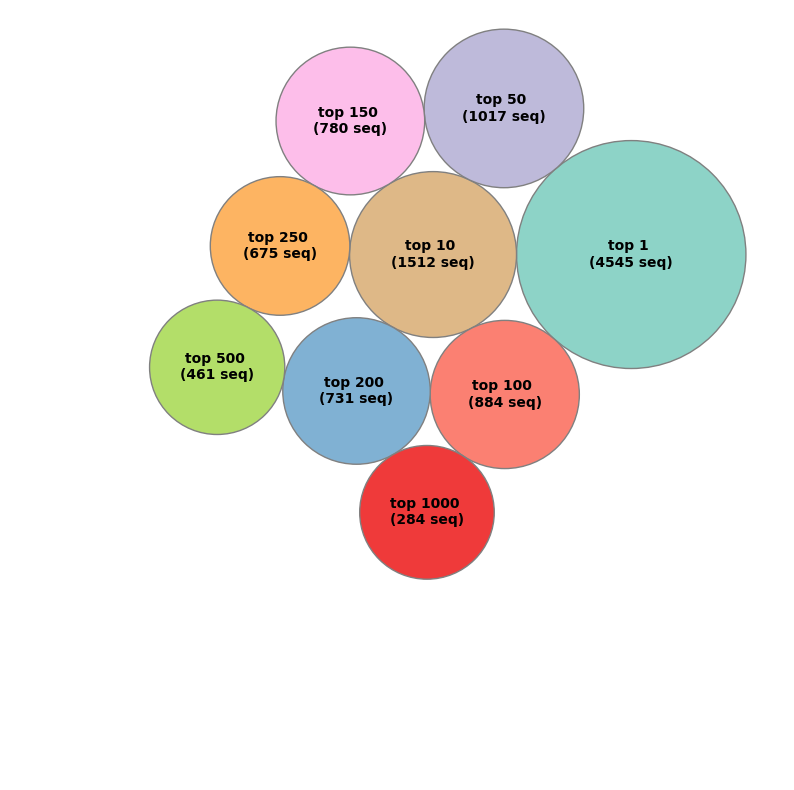

In [10]:
colors = ['#8dd3c7', 'burlywood', '#bebada', '#fb8072', "#fdbeea", '#80b1d3', '#fdb462', '#b3de69', '#ef3a3a', '#994e58'] 
          #'#ada36f', '#b00a62', '#814087', '#f48798', "#34152e", '#66343b', '#994e58', "#95829e", "#337755","#fecc4d" ]
plot_labels = [f'top {count_ith_fam.index[i]} \n({count_ith_fam["Count of top ith Family"].iloc[i]} seq)' for i in range(len(count_ith_fam))]

circle_plot = circlify.circlify(top_families['counts'].tolist()[:20], 
                               target_enclosure=circlify.Circle(x=0, y=0))

# Note that circle_plot starts from the smallest to the largest, we have to reverse the list
circle_plot.reverse()
fig, axs = plt.subplots(figsize=(10, 10))

# Find axis boundaries
lim = max(max(abs(circle.x) + circle.r, 
              abs(circle.y) + circle.r,) 
          for circle in circle_plot)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Display circles.
for circle, color, label in zip(circle_plot, colors, plot_labels):
    x, y, r = circle
    axs.add_patch(plt.Circle((x, y), r, linewidth=1, facecolor=color, 
                             edgecolor='grey'))
    plt.annotate(label, (x, y), va='center', ha='center', fontweight='bold')
plt.axis('off')
plt.show()

### Undersampling: selecting top frequent families

Naturally, such a large set of classes would be difficult to represent. Predicting the probability of each class would imply and output size of 17,929. Not to mention the one-hot encoding of the classes which would result in a y vector of dimensions (nb_sequences * 17,929) which would be too sparse and too memory expensive to represent. Consequently, we decided to exclusively work with the top 100 protein family, and discard the rest for now. 

There is a large discrepency in the sizes of the families even in the top 100 biggest protein families. Notably, the largest family which is almost double in size compared to the second largest. Such an imbalance in the dataset should be kept in mind and may need to be accounted for later in the model.

In [11]:
def sample_freq_families(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Returns dataframe containing only the sequences in the dataset that belong to the top_frequent families list
    """
    indices = dataset["family_accession"].isin(top_families.protein_family.to_list())
    return dataset.loc[indices, :]

train_df = sample_freq_families(raw_train_df)
dev_df = sample_freq_families(raw_dev_df)
test_df = sample_freq_families(raw_test_df)
all_df = pd.concat([train_df, dev_df, test_df])


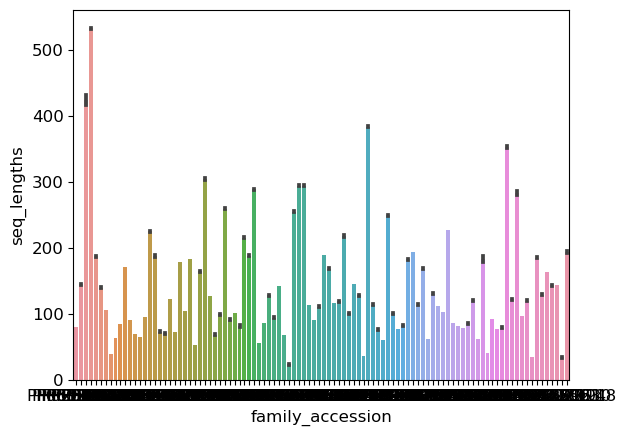

In [70]:
train_df['seq_lengths'] = train_df["sequence"].map(len)
sns.barplot(x = "family_accession", y="seq_lengths", data=train_df);
#not a lot of variability in seq length within a family. Let's undersample

split      0.955974
seq_len    0.955974
dtype: float64% of all sequences fall below sequence length = 300


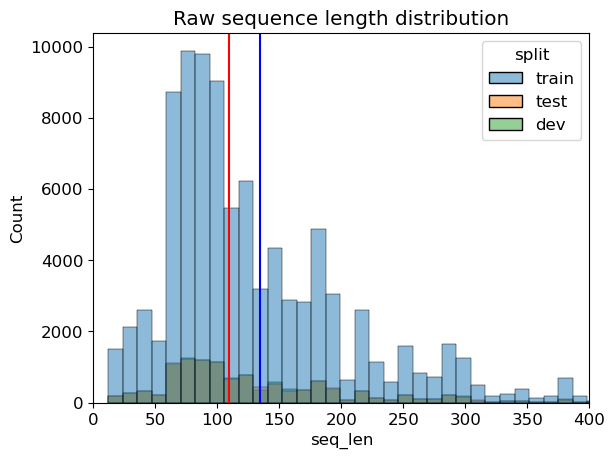

In [65]:
def compute_seq_length(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the length of the sequences in provided dataset. used to plot sequences' length against per split.
    
    Parameters
    ----------
    dataset: pd.DataFrame
        dataframe containing a 'sequence' field of type string.
    
    Return
    ------
    pd.DataFrame:
        dataframe with 2 fields: 'split' indicating the set split name and 'seq_len' with the sequence length.
    """
    return pd.DataFrame({
        "split": dataset["split"].to_list(),
        "seq_len" : dataset["sequence"].apply(len).to_list()
    })

#calculate length by dataset
train_seq_len = compute_seq_length(train_df)
dev_seq_len = compute_seq_length(dev_df)
test_seq_len = compute_seq_length(test_df)

# plot seuquence length of all datasets
seq_len_grouped = pd.concat([train_seq_len, test_seq_len, dev_seq_len])
len_mean = seq_len_grouped["seq_len"].mean()
len_median = seq_len_grouped["seq_len"].median()
sns.histplot(data=seq_len_grouped, x="seq_len", hue="split", bins=100)
plt.axvline(x = len_mean, color = 'b')
plt.axvline(x = len_median, color = 'r')
plt.xlim((0, 400))
plt.title("Raw sequence length distribution")
perc_below_300 = seq_len_grouped[seq_len_grouped["seq_len"] < 300].count()/len(seq_len_grouped)
print(f"{perc_below_300}% of all sequences fall below sequence length = 300");

We see that the average sequence lengths is not the same across protein families, and the variability of length within a family is negligeable. The plot of counts per sequence length showcases the distribution which follows a narrow right-skewed bell-shape. The median (in red) falls very close to the mode, around 100 amino-acids length while the mean falls a bit further around 130. more than 95% of the sequences have a length of 300 or less, making a input sequence length of 300 a good choice for the model.

### Amino Acids distribution

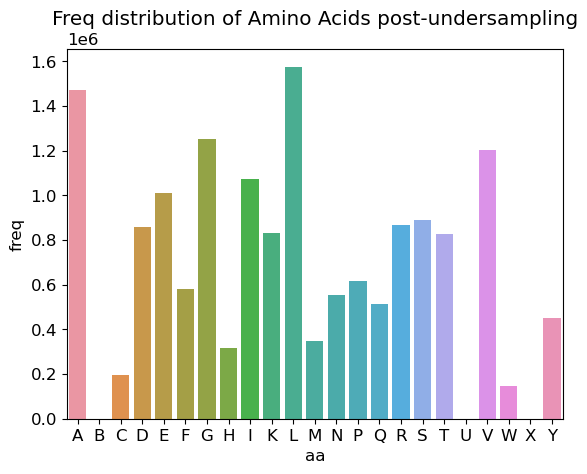

In [66]:
# count amino acids

def compute_aa_freq(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the frequency of occurence of all amino acids in the provided dataset.
    
    Parameters
    ----------
    dataset: pdd.DataFrame
        dataframe with one required field: "sequence", of type string, containing the amino acid sequence in upper case.
    
    Return 
    ------
    pd.Dataframe
        dataframe with 2 fields "aa" containing all occuring amino acids, and "freq" with the count of their occurence.
        sorted alphabetically based on the "aa" field.
    """
    
    freq_per_acid = Counter("".join(dataset["sequence"]))
    freq_df = pd.DataFrame({
        "aa": list(freq_per_acid.keys()), 
        "freq": list(freq_per_acid.values())
    })
    
    return freq_df.sort_values('aa')


seq_df = pd.concat([train_df, dev_df, test_df])
aa_freq_df = compute_aa_freq(seq_df)
sns.barplot(x="aa", y="freq", data=aa_freq_df).set(title='Freq distribution of Amino Acids post-undersampling');

### PreProcessing

Some pre-preocessing of the sequences and their labels is required to ensure that the data is in a format that can be accepted as input for the models.


In [15]:
aa_index = {aa: idx+1 for idx, aa in enumerate(aa_freq_df["aa"].to_list())}
input_dim = len(aa_index) + 1

def encode_aa(seq: str) -> list[int]:
    """
    Encodes a string sequence of amino acids into an array of integers. each amino acid is replaced by 
        its corresponding integer based on the amino acid index
    returns the resulting array of integers 
    """
    return [aa_index[c] for c in seq]

def preProcess(dataset: pd.DataFrame) -> tuple[np.ndarray, pd.DataFrame]:
    """
    Preprocess the dataset to input in model. encodes the string sequence of amino acid letters into integers.
    one-hot encodes the respecive protein family 
    
    Parameters
    ----------
    dataset: pd.DataFrame
        dataframe with at least 2 fields. A field called "sequence" of type string, as a sequence of 
        upper case letters representing the chain of amino acids. A field called "family_accession", 
        of type string, representing the class of the protein.
    
    Returns
    -------
    Tuple: (np.ndarray, pd.DataFrame)
        returns a numpy array of the padded sequences, one-hot encoded and ready to be fed to the model, and a 
        Dataframe with each row containing the one-hot encoded version of the family_accession field
    """
        
    enc_df = [encode_aa(seq) for seq in dataset["sequence"]] 
    padded = pad_sequences(enc_df,  maxlen=max_seq_len, padding="post", truncating="post")
    one_hot = pd.get_dummies(dataset['family_accession'])
    
    return padded, one_hot

# padding to make all sequences of same length
x_train, y_train = preProcess(train_df)
x_dev, y_dev = preProcess(dev_df)
x_test, y_test = preProcess(test_df)
print(x_train.shape, x_dev.shape, x_test.shape)


(92983, 300) (11565, 300) (11565, 300)


In [16]:
print(y_train.shape, y_dev.shape, y_test.shape)
print(type(x_train), type(y_train))

(92983, 100) (11565, 100) (11565, 100)
<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


## Methods

The first model to explore should be a basic and simple one from which we can extrapolate and which we can compare to more complex models. We first chose a simple embedding model with a classification layer. This baseline model takes in the one-hot encoded sequence, encodes contextual and positional information provided in the protein sequence in the latent space before performing a couple of transformation and feeding them to the classifier. The final classification layer uses the softmax activation function to predict the probability of the 100 layers and classifies based on the class with the highest probability.


In [17]:
class PositionEmbeddingLayer(layers.Layer):
    """
    Layer that performs positional embedding, context embedding. Returns the addition of the two resulting tensors.
    """
    def __init__(self, seq_length, input_dim, embedding_dim, **kwargs):
        """
        Parameters
        ----------
        seq_length: int
            length of input sequences
        input_dim: int
            size of the vocabulary, here the number of all possible amino acids
        embedding_dim: int
            dimension of the latent encoding space
        **kwargs: 
            Keras Layer arguments
        """
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.aa_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)
        self.pos_encoding = Embedding(input_dim=seq_length, output_dim=embedding_dim)
 
    def call(self, inputs):
        seq_dim = tf.shape(inputs)[-1]
        pos_indices = tf.range(seq_dim)
        aa_embeddings = self.aa_embedding(inputs)
        pos_encodings = self.pos_encoding(pos_indices)
        return aa_embeddings + pos_encodings

class PosEmbeddingModel(tf.keras.Model):
    """
    Baseline position embedding classifier
    """
    def __init__(self, input_dim: int, embedding_dim: int, out_dim: int, max_seq_len: int, dropout_rate: float=0.25):
        """
        Parameters
        ----------
        input_dim: int
            dimension of the input vector
        embedding_dim: int
            dimension of the embedding or latent space to which the input is encoded
        out_dim: int
            size of the output classification layer, the number of classes to predict from.
        max_seq_len: int:
            max lebgth of input sequence (after padding/truncating)
        dropout_rate: float:
            dropout rate of the dropout layers
        """
        
        # super class
        super(PosEmbeddingModel, self).__init__()
        
        # define layers
        self.pos_embedding = PositionEmbeddingLayer(seq_length=max_seq_len, input_dim=input_dim, embedding_dim=embedding_dim)
        self.pos_embedding_dropout = Dropout(dropout_rate)
        self.flatten = Flatten()
        self.embedding = Dense(128, activation="relu")
        self.embedding_dropout = Dropout(dropout_rate)
        self.classifier = Dense(out_dim, activation="softmax")
        
    def get_seq_embeddings(self, x: tf.Tensor, training=True):
        """
        Performs embedding of the sequences
        """
        x = self.pos_embedding(x)
        x = self.pos_embedding_dropout(x, training)
        x = self.flatten(x)
        x = self.embedding(x)
        x = self.embedding_dropout(x, training)
        return x
    
    def call(self, inputs: tf.Tensor, training=True):
        """
        call model on input
        """
        x = self.get_seq_embeddings(inputs, training)
        return self.classifier(x)

In [18]:
def plot_history(history: keras.callbacks.History):
    """
    Plots the training and validation learning curves. Plots precision, recall, loss and accuracy based on model history
    """

    fig, ((loss_plot, acc_plot), (precision_plot, recall_plot)) = plt.subplots(2, 2, figsize=(8, 4),
                                                                               constrained_layout = True)
    fig.suptitle("Learning Curves")
    
    loss_plot.plot(history.history["loss"])
    loss_plot.plot(history.history["val_loss"])
    loss_plot.set_ylabel("loss")
    loss_plot.set_xlabel("epoch")
    loss_plot.legend(["train", "val"], loc="upper right")
    
    acc_plot.plot(history.history["accuracy"])
    acc_plot.plot(history.history["val_accuracy"])
    acc_plot.set_ylabel("accuracy")
    acc_plot.set_xlabel("epoch")
    acc_plot.legend(["train", "val"], loc="lower right")
    
    precision_plot.plot(history.history["precision"])
    precision_plot.plot(history.history["val_precision"])
    precision_plot.set_ylabel("precision")
    precision_plot.set_xlabel("epoch")
    precision_plot.legend(["train", "val"], loc="lower right")
    
    recall_plot.plot(history.history["recall"])
    recall_plot.plot(history.history["val_recall"])
    recall_plot.set_ylabel("recall")
    recall_plot.set_xlabel("epoch")
    recall_plot.legend(["train", "val"], loc="lower right")

def plotEmbeddings(model: PosEmbeddingModel, df: pd.DataFrame, top_families: list, nb_families: int, start_idx=0):
    """
    Performs tSNE dimension reduction of the embeddings of the model and plots the embedding of the provided dataset 
    in the reduced space. plots the results.
    
    Parameters
    ----------
    model: PosEmbeddingModel
        Keras classifier based on input embeddings
    df: pd.DataFrame
        set of sequence to plot with 2 required fields "family_accession" of type str and "sequence" of type str
    top_families: list
        list of the protein family accessions, assumed to be ordered. Sequences in df that belong to one of these families would be included
        the plot
    nb_families: int
        number of families to consider based on the top_families argument, starting the start index
    start_idx: int
        start index based on which elements in top_families argument are considered for the plot.
    """
    
    #Edge case:
    end_idx = start_idx + nb_families
    if end_idx > len(top_families):
        print("Check your indices")
        return
        
    dataset = tf.data.Dataset.from_tensor_slices(x_test)
    dataset = dataset.batch(BATCH_SIZE)
    
    embeddings = []
    for batch in dataset:
        embeddings.append(model.get_seq_embeddings(batch))
    embeddings = np.vstack(embeddings)
    
    x_test_tsne = TSNE(n_components=2, random_state=305).fit_transform(embeddings)
    plot_df = test_df[["family_accession"]]
    plot_df["tSNE1"] = x_test_tsne[:,0]
    plot_df['tSNE2'] = x_test_tsne[:,1]
    plot_df_top_label= plot_df.loc[plot_df.family_accession.isin(top_families[start_idx:end_idx])]
    plot_df_top_label.reset_index(inplace=True)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(8,8))
    sns.jointplot(data=plot_df_top_label, x='tSNE1', y='tSNE2', hue = 'family_accession', height=10)

In [19]:
input_dim = len(aa_index) + 1

#define optimizer 
optim = tf.keras.optimizers.Adam(0.001)

#Build model
posEmbeddingModel = PosEmbeddingModel(input_dim, embedding_dim, num_labels, max_seq_len)
posEmbeddingModel.build(x_train.shape)
posEmbeddingModel.compile(optimizer=optim, loss="categorical_crossentropy", 
                          metrics=["accuracy", keras.metrics.Precision(name="precision"), 
                                   keras.metrics.Recall(name="recall")])
posEmbeddingModel.summary()


Model: "pos_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_layer (P  multiple                 10368     
 ositionEmbeddingLayer)                                          
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  1228928   
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  12900     
                                               

In [20]:
callbacks = [EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1)]
#training
history = posEmbeddingModel.fit(
    x_train, y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=(x_dev, y_dev),
    #class_weight=label_weights,
    callbacks=callbacks
)

Epoch 1/10
2906/2906 [==============================] - 58s 19ms/step - loss: 0.3426 - accuracy: 0.9203 - precision: 0.9872 - recall: 0.8902 - val_loss: 0.0228 - val_accuracy: 0.9938 - val_precision: 0.9968 - val_recall: 0.9928
Epoch 2/10
2906/2906 [==============================] - 58s 20ms/step - loss: 0.0306 - accuracy: 0.9911 - precision: 0.9931 - recall: 0.9897 - val_loss: 0.0259 - val_accuracy: 0.9938 - val_precision: 0.9953 - val_recall: 0.9933
Epoch 3/10
2906/2906 [==============================] - 56s 19ms/step - loss: 0.0244 - accuracy: 0.9927 - precision: 0.9938 - recall: 0.9920 - val_loss: 0.0227 - val_accuracy: 0.9948 - val_precision: 0.9959 - val_recall: 0.9942
Epoch 4/10
2906/2906 [==============================] - 55s 19ms/step - loss: 0.0230 - accuracy: 0.9931 - precision: 0.9939 - recall: 0.9927 - val_loss: 0.0265 - val_accuracy: 0.9946 - val_precision: 0.9958 - val_recall: 0.9942
Epoch 5/10
2906/2906 [==============================] - 56s 19ms/step - loss: 0.0219 - a

#### Exploring Results

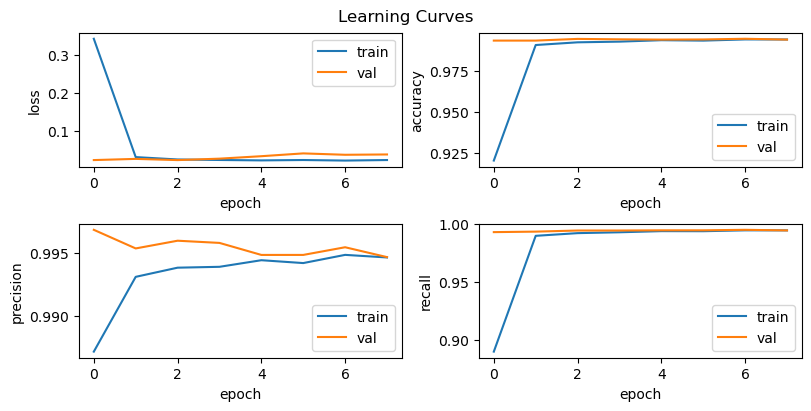

In [21]:
plot_history(history)

In [22]:
posEmbeddingModel.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)

362/362 [==============================] - 2s 6ms/step - loss: 0.0225 - accuracy: 0.9950 - precision: 0.9953 - recall: 0.9946


[0.02246582694351673,
 0.9949848651885986,
 0.9953271150588989,
 0.9945525527000427]

### Transformer 

Transformer is a more complex and bulkier architecture model that has proved extremely performant in NLP tasks. It performs positional and contextual embeddings on the input before feeding them to subsequent layers. Below we implement a simple transformer model with one transformer block.

In [27]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class ProteinTransformer(tf.keras.Model):
    """
    Baseline position embedding classifier
    """
    def __init__(self, input_dim: int, embedding_dim: int, out_dim: int, max_seq_len: int, dropout_rate: float=0.25):
        """
        Parameters
        ----------
        input_dim: int
            dimension of the input vector
        embedding_dim: int
            dimension of the embedding or latent space to which the input is encoded
        out_dim: int
            size of the output classification layer, the number of classes to predict from.
        max_seq_len: int:
            max lebgth of input sequence (after padding/truncating)
        dropout_rate: float:
            dropout rate of the dropout layers
        """
        
        # super class
        super(ProteinTransformer, self).__init__()
        
        #layers
        self.embedding_layer = PositionEmbeddingLayer(max_seq_len, input_dim, embedding_dim)
        self.transformer_block = TransformerBlock(embedding_dim, num_heads=2, ff_dim=32)
        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)
        self.classifier = layers.Dense(out_dim, activation="softmax")
        
    def call(self, inputs: tf.Tensor, training=True):
        """
        call model on input
        """
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.pooling(x)
        x = self.dropout(x)
        return self.classifier(x) 

In [28]:
#define optimizer 
optim = tf.keras.optimizers.Adam(0.001)

#Build model
proteinTransformerModel = ProteinTransformer(input_dim, embedding_dim, num_labels, max_seq_len)
proteinTransformerModel.build(x_train.shape)
proteinTransformerModel.compile(optimizer=optim, loss="categorical_crossentropy", 
                          metrics=["accuracy", keras.metrics.Precision(name="precision"), 
                                   keras.metrics.Recall(name="recall")])
proteinTransformerModel.summary()


Model: "protein_transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_layer_3   multiple                 10368     
 (PositionEmbeddingLayer)                                        
                                                                 
 transformer_block (Transfor  multiple                 10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  3300      
                                             

In [29]:
callbacks = [EarlyStopping(
        monitor="val_loss", 
        patience=patience, 
        restore_best_weights=True, 
        verbose=1)]
#training and monitoring 
history = proteinTransformerModel.fit(
    x_train, y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=(x_dev, y_dev),
    callbacks=callbacks
)

Epoch 1/10
2906/2906 [==============================] - 364s 123ms/step - loss: 2.4233 - accuracy: 0.3081 - precision: 0.8010 - recall: 0.0716 - val_loss: 1.2567 - val_accuracy: 0.6016 - val_precision: 0.8348 - val_recall: 0.3382
Epoch 2/10
2906/2906 [==============================] - 356s 123ms/step - loss: 1.1510 - accuracy: 0.6368 - precision: 0.8166 - recall: 0.4380 - val_loss: 0.7470 - val_accuracy: 0.7703 - val_precision: 0.8537 - val_recall: 0.6813
Epoch 3/10
2906/2906 [==============================] - 372s 128ms/step - loss: 0.7444 - accuracy: 0.7727 - precision: 0.8595 - recall: 0.6850 - val_loss: 0.4344 - val_accuracy: 0.8692 - val_precision: 0.9092 - val_recall: 0.8366
Epoch 4/10
2906/2906 [==============================] - 382s 131ms/step - loss: 0.5156 - accuracy: 0.8447 - precision: 0.8919 - recall: 0.8012 - val_loss: 0.3172 - val_accuracy: 0.9056 - val_precision: 0.9254 - val_recall: 0.8929
Epoch 5/10
2906/2906 [==============================] - 327s 113ms/step - loss: 

In [30]:
proteinTransformerModel.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)

362/362 [==============================] - 18s 50ms/step - loss: 0.1293 - accuracy: 0.9630 - precision: 0.9688 - recall: 0.9589


[0.12925036251544952,
 0.9629917740821838,
 0.9688127636909485,
 0.9589278101921082]

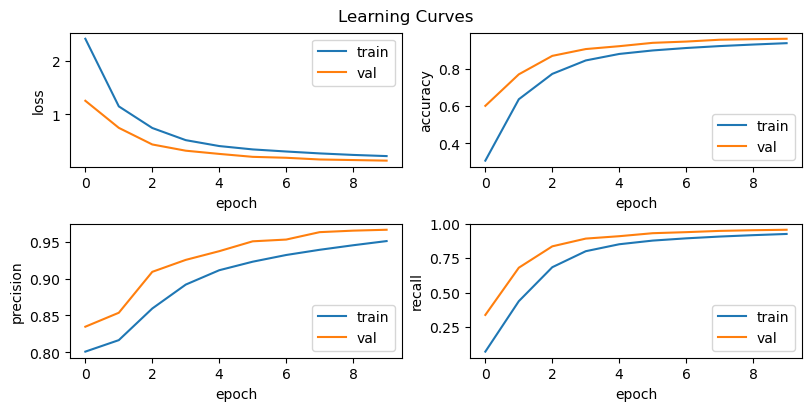

In [31]:
plot_history(history)

## Results

Given the results above, we chose the first baseline model as it it proved to be fitter and more compatible wth the task at hand. To properly curate it, we explore the lower-dimensional distribution of the test sequences in  the learned embedding space.

### tSNE of Embeddings

<Figure size 800x800 with 0 Axes>

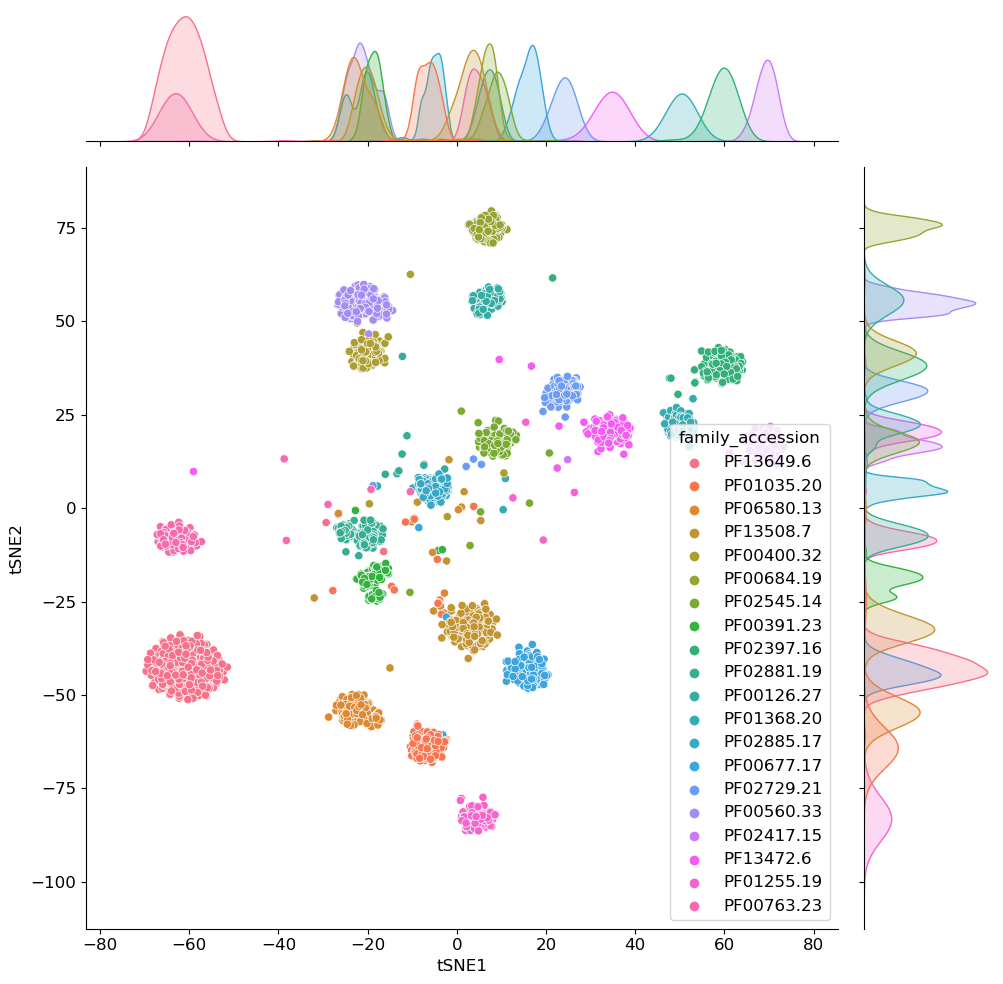

In [71]:
plotEmbeddings(posEmbeddingModel, x_test, top_families.protein_family.to_list(), nb_families=20);

<Figure size 800x800 with 0 Axes>

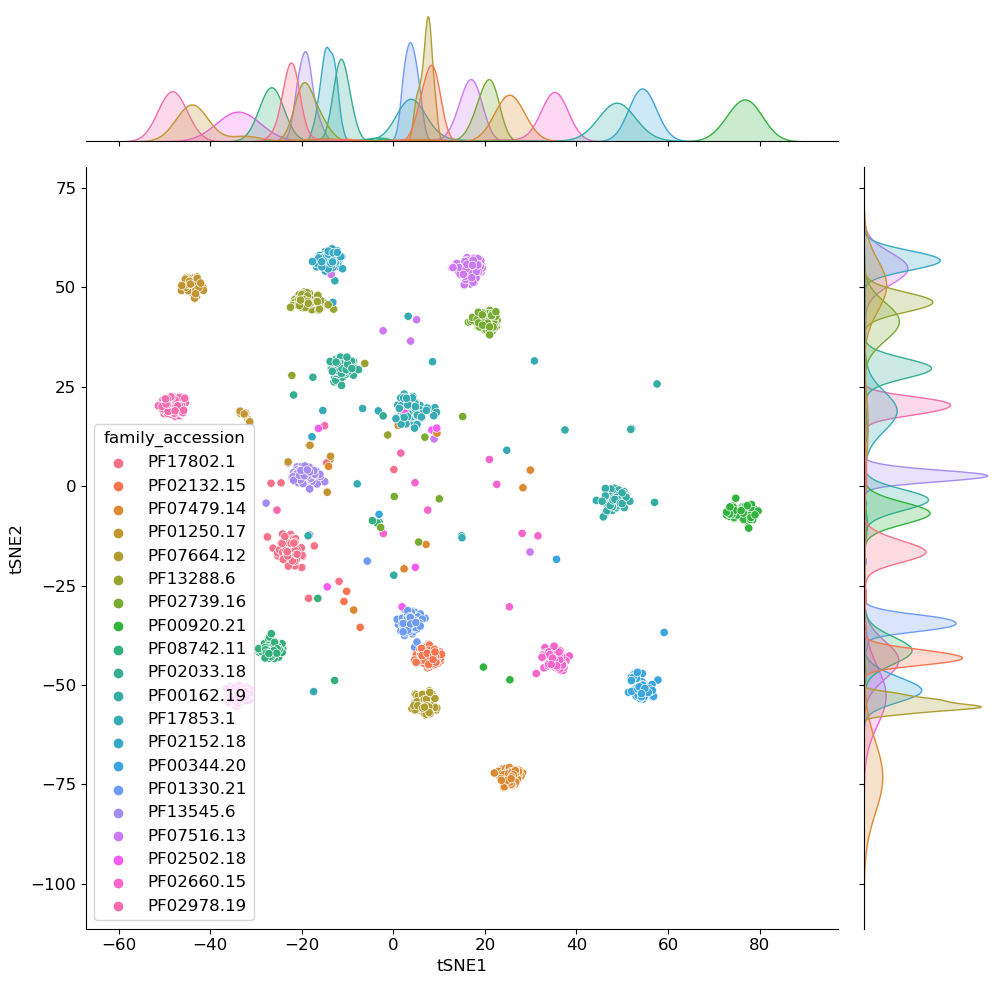

In [72]:
plotEmbeddings(posEmbeddingModel, x_test, top_families.protein_family.to_list(), nb_families=20, start_idx=80);